In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Hands-on Activity 26.3 (Physics-informed regularization: Solving uncertainty propagation problems) 

## Objectives

+ Learn how to solve stochastic PDEs with neural networks.


In [4]:
import numpy as np
import torch
import torch.nn as nn

# This is useful for taking derivatives:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

## Solving stochastic PDEs

Consider the boundary value problem we introduced back in [Hands-on Activity 10.4](http://localhost:8888/notebooks/me597/data-analytics-se/activities/hands-on-10.4.ipynb). We have a heterogeneous rod with no heat sources.
The temperature of the rod is governed by the steady state heat equation on:
$$
\frac{d}{dx}\left(c(x,\xi)\frac{d}{dx}T(x,\xi)\right) = 0,
$$
for $x$ between $0$ and $1~\;\mbox{m}$ and boundary values:
$$
T(0) = 400^\circ\mbox{C}\;\mbox{and}\;T(1~\mbox{m}) = 4^\circ\mbox{C}.
$$
We are interested in cases in which we are uncertain about the conductivity, $c(x,\xi)$.
Here $\xi$ captures all the information that you need to specify the conductivity.
Let's recall the model we used for the conductivity back in 10.4:

In [114]:
class Rod(object):
    
    """
    A class representing a rod made out of different materials.
    
    Arguments:
    
    segment_coords   -   Coordinates of the segments (both left and right). Total N + 1
                         if segments are N.
    mat_id           -   The material ids on each segment. Total N. Values must start
                         at 0 and go sequential to the maximum number of materials
                         we have on the rod.
    mat_cond         -   The conductivity associaed with each unique material id.
    """
    
    def __init__(self, segment_coords, mat_id, mat_cond):
        # Save segments for later
        self.segment_coords = np.sort(segment_coords)
        # The total number of segments
        self.num_segments = self.segment_coords.shape[0] - 1
        # Save the material id on each segment for later
        self.mat_id = mat_id
        # The number of unique materials
        self.num_mat = len(np.unique(self.mat_id))
        # The conductivity on each segment
        self.segment_cond = np.array([mat_cond[m] for m in mat_id])
        
    def _get_conductivity(self, x):
        """
        Evaluate the conductivity at location x, assuming x is a scalar.
        """
        # Find the segment that contains x
        for i in range(self.num_segments):
            if self.segment_coords[i] <= x and x <= self.segment_coords[i + 1]:
                return self.segment_cond[i]
            
    def get_conductivity(self, x):
        """
        Evaluate the conductivity at location x. This works when x is a scalar or
        a numpy array.
        """
        if isinstance(x, float):
            return self._get_conductivity(x)
        # This checks if x is a numpy array. The function will fail other wise.
        assert isinstance(x, np.ndarray)
        # And it will only work with 1D arrays
        assert x.ndim == 1
        # This evaluates the conductivity at all the elements of x and returns
        # a numpy array
        return np.array([self._get_conductivity(xx) for xx in x])
    
    def __repr__(self):
        """
        Get a string representation of the rod.
        """
        s = 'SEGID\tLeft\tRight\tMat.\tCond.\n'
        s += '-' * 37 + '\n'
        for i in range(self.num_segments):
            s += ' {0:d}\t{1:1.2f}\t{2:1.2f}\t{3:d}\t{4:1.2f}\n'.format(i, segment_coords[i],
                                                                 segment_coords[i+1],
                                                                 material_on_each_segment[i],
                                                                 segment_cond[i])
        return s
    
    def plot(self, ax=None):
        """
        Plots the bar. Returns the axes object on which the rod is plot.
        
        Arguments:
        
        ax    -    An axes object to plot on. If not given, a new one will be created.
        """
        from matplotlib.patches import Rectangle
        if ax is None:
            fig, ax = plt.subplots()
        for i in range(self.num_segments):
            mat_segment = Rectangle((self.segment_coords[i], -0.1), 
                                    width=self.segment_coords[i+1] - self.segment_coords[i],
                                    height=0.1, color=sns.color_palette()[self.mat_id[i]])
            ax.add_patch(mat_segment)
        ax.set_ylim(-0.1, 1.1)
        return ax
    

class RandomRod(object):
    
    """
    A class modeling a random rod.
    
    Arguments:
    
    av_num_segments    -    The ``rate`` of the Poisson distribution giving
                            the number of segments.
    mat_probs          -    The probabilities of the categorical specifying
                            each material goes on each segment.
    mat_cond         -   The conductivity associaed with each unique material id.
    """
    
    def __init__(self, av_num_segments, mat_probs, mat_cond):
        # Save some info internally for later usage
        self.av_num_segments = av_num_segments
        self.mat_probs = mat_probs
        self.mat_cond = mat_cond
        # Make the Poisson variable corresponding to the number of segments
        self.D = st.poisson(av_num_segments)
        # Make the Uniform giving the location of the segment coordinates
        self.U = st.uniform()
        # Make the Categorical random variable that allows us to pick the material
        # id on each segment
        self.M = st.rv_discrete(name='M', values=(np.arange(len(mat_probs)), mat_probs))
        
    def _rvs(self):
        """
        Generate a single random rod.
        """
        # Draw the number of segments
        d = self.D.rvs()
        # Draw the coordinates
        segment_coords = np.hstack([[0.0], np.sort(self.U.rvs(size=d - 1)), [1.0]])
        # Draw the material type on each segment
        mat_ids = self.M.rvs(size=d)
        # Generate the rod
        return Rod(segment_coords, mat_ids, self.mat_cond)
    
    def rvs(self, size=1):
        """
        Generate many random rods.
        """
        if size == 1:
            return self._rvs()
        return [self._rvs() for _ in range(size)]

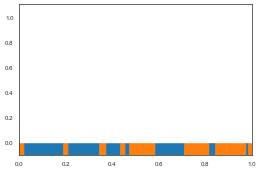

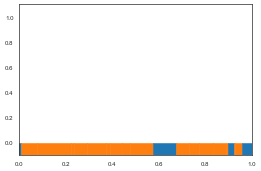

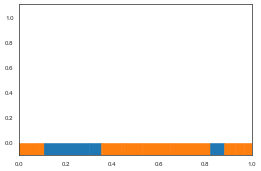

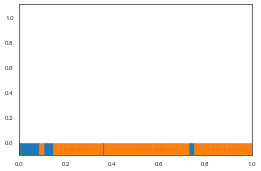

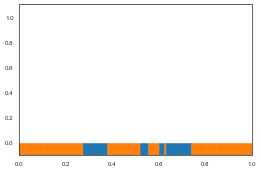

In [115]:
# Create the random rod object
R = RandomRod(20,         # The number of segments
              [0.3, 0.7],  # The concentration of each material
              [0.045, 38.0])  # The thermal conductivity of each material
# Let's sample a few of them and plot them
for n in range(5):
    fig, ax = plt.subplots(dpi=50)
    R.rvs().plot(ax=ax)

We also had a solver for the equation for random rods.
Let's bring it back.

In [116]:
# Fipy is used to solve the boundary value problem using a finite volume scheme
# You may have to install it if you don't have it using:
# RUN THIS BLOCK IF YOU HAVEN'T INSTALLED fipy yet
!pip install fipy

In [117]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, nx=500, value_left=400.0, value_right=4.0):
        self.nx = nx
        self.dx = 1. / nx
        # A computational mesh with nx elements
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        # A variable that represents that temperature on the mesh
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        # A variable that represents the thermal conductivity
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        # The constrain on the left boundary
        self.phi.constrain(value_left, self.mesh.facesLeft)
        # The constrain on the right boundary
        self.phi.constrain(value_right, self.mesh.facesRight)
        # The The diffusion term
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, rod):
        """
        Evaluates the code at a specific xi.
        """
        # Find the values of the mesh points
        x = self.mesh.faceCenters.value.flatten()
        # Evaluate the conductivity on these points using the rod model
        cond_val = rod.get_conductivity(x)
        # Update conductivity values in the equation
        self.C.setValue(cond_val)
        # Solve the equation
        self.eq.solve(var=self.phi)
        # Return the solution
        return x, self.phi.faceValue()

And recall here, that the solver is used as follows:

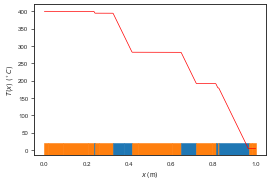

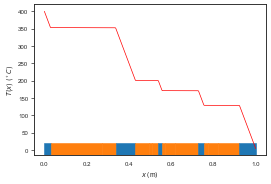

In [118]:
solver = SteadyStateHeat1DSolver(nx=500)
for i in range(2):
    fig, ax = plt.subplots(dpi=50)
    rod = R.rvs()
    x, y = solver(rod)
    # plot the rod
    rod.plot(ax=ax)
    # Get rid of the y ticks for the rod
    ax.set_yticks([])
    # Get another axis to plot the temperature
    ax1 = ax.twinx()
    # Make sure the ticks for this axis are on the left
    ax1.yaxis.tick_left()
    # Same for the label
    ax1.yaxis.set_label_position("left")
    # Plot the temperature
    ax1.plot(x, y, 'r', lw=1)
    ax.set_xlabel('$x$ (m)')
    ax1.set_ylabel(r'$T(x)\;(^\circ C)$');

Alright. Now that we have recalled where we were, let's get back to physics informed neural network.
We will use one to learn the temperature $T(x,\xi)$ as a function of any thermal conductivity captured by $\xi$.
What exactly do we mean by $\xi$ here? We mean the rod conductivity. But we would have to pick a fixed dimensional parameterization of the rod conductivity.
The way we will achieve this is by assuming that the conductivity is always sampled on the same spatial positions.
Here is how:

In [119]:
# Here are the fixed spatial positions on which we will be sampling the conductivity
xs = np.linspace(0, 1, 100)
# Here is a random rod
rod = R.rvs()
# And here is the discretization as 500-dimensional vector
xi = np.log(rod.get_conductivity(xs))
# Here it is
print(xi)

[-3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279
 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279
 -3.10109279  3.63758616  3.63758616  3.63758616 -3.10109279 -3.10109279
 -3.10109279 -3.10109279  3.63758616  3.63758616  3.63758616  3.63758616
  3.63758616  3.63758616  3.63758616  3.63758616  3.63758616  3.63758616
  3.63758616  3.63758616  3.63758616  3.63758616  3.63758616  3.63758616
  3.63758616  3.63758616  3.63758616  3.63758616  3.63758616  3.63758616
  3.63758616  3.63758616  3.63758616  3.63758616  3.63758616  3.63758616
 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279
 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279
 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279
 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279
 -3.10109279 -3.10109279 -3.10109279 -3.10109279 -3.10109279  3.63758616
  3.63758616  3.63758616  3.63758616  3.63758616  3

Notice that I took the log of the conductivity because the neural network will like it more...

Now that we have $\xi$, let's introduce our parameteterization of the temperature using a neural network.
We need to make sure that the left and right boundary conditions are satisfied.
We will take it to be:
$$
T(x,\xi) = A(x) + x(1-x)N(x,\xi;\theta),
$$
where $A(x)$ must be picked so that the boundary conditions are satisfied, and $N(x,\xi;\theta)$ is a neural network with parameters $\theta$.

Here is the simplest such choice for the boundary function:
$$
A(x) = T_0 + (T_1-T_0)x,
$$
where $T_0 = T(0)$ and $T_1 = T(1)$.
That was easy...

Finally, we need to specify what is the loss function we should be minimizing.
We are going to use this the expectation of the Dirichlet principle (energy):
$$
L(\theta) = \frac{1}{2}\mathbb{E}_{\xi}\left[\int_0^1 \parallel c(x,\xi)\nabla_x T(x,\xi)\parallel^2dx\right].
$$
Okay, let's do it.

In [120]:
import torch.nn.functional as F

# left boundary
T0 = 400.0
# right boundary
T1 = 4.0

# The number of xi's we are going to have
num_xi = xs.shape[0]

# The part for satisfying the boundary
A = lambda x: T0 + (T1 - T0) * x

# And the neural network
class NNModel(nn.Module):
    
    def __init__(self, num_xi=500):
        super(NNModel, self).__init__()
        # Some layers that process just xi
        self.xi_fc1 = nn.Linear(num_xi, num_xi)
        self.xi_fc2 = nn.Linear(num_xi, num_xi)
        self.xi_fc3 = nn.Linear(num_xi, num_xi)
        # Now there are some dense layers that combine everything
        self.fc4 = nn.Linear(1 + num_xi, 1 + num_xi)
        self.fc5 = nn.Linear(1 + num_xi, int(num_xi / 2))
        self.fc6 = nn.Linear(int(num_xi / 2), int(num_xi / 4))
        self.fc7 = nn.Linear(int(num_xi / 4), int(num_xi / 8))
        # End in a single dimension
        self.fc8 = nn.Linear(int(num_xi / 8), 1)
    
    def forward(self, x, xi):
        # Pass xi through some dense layers
        out1 = F.relu(self.xi_fc1(xi))
        out2 = F.relu(self.xi_fc2(out1))
        out3 = F.relu(self.xi_fc3(out2))
        # Expand out3 to match the dimension of x
        expanded_out3 = out3.expand((x.shape[0], -1))
        # Combine with x
        combined = torch.cat((x, expanded_out3), dim=1)
        # Continue with the next
        out4 = F.relu(self.fc4(combined))
        out5 = F.relu(self.fc5(out4))
        out6 = F.relu(self.fc6(out5))
        out7 = F.relu(self.fc7(out6))
        out8 = F.relu(self.fc8(out7))
        return out8
    
# And here is an instance of the net
N = NNModel(num_xi)

# Here is our model for T
T = lambda x, xi: A(x) + x * (1 - x) * N(x, xi)

# The conductivity model
dx = xs[1] - xs[0]
c = lambda x, xi: torch.exp(xi[:, torch.floor(x / dx).long().flatten()])

# The loss function
def loss(x, xi): 
    x.requires_grad = True
    return torch.mean((c(x, xi) * grad(T(x, xi), x)) ** 2)

In [121]:
# Let's see now if a stochastic optimizer makes a difference
adam = torch.optim.Adam(N.parameters(), lr=0.1)

# The batch size you want to use (how many points to use per iteration)
n_batch = 500

# The maximum number of iterations to do
max_it = 100000

losses = []
for i in range(max_it):
    # Randomly pick n_batch random x's:
    x = torch.rand(n_batch, 1)
    # Randomly pick a rod
    rod = R.rvs()
    xi = torch.Tensor(np.log(rod.get_conductivity(xs)))[None, :]
    # Zero-out the gradient buffers
    adam.zero_grad()
    # Evaluate the loss
    l = loss(x, xi)
    # Calculate the gradients
    l.backward()
    # Update the network
    adam.step()
    losses.append(l.item())
    # Print the iteration number
    if i % 100 == 99:
        print(l.item())

176172896.0
77893392.0
165754240.0
200634064.0
175719920.0
173454992.0
158506496.0
147182096.0
172096032.0
143559104.0
171190064.0
91026152.0
197916160.0
173002000.0
188856464.0
162130368.0
153976736.0
138123152.0
207881824.0
221018384.0
200634064.0
176625888.0
196557200.0
96460392.0
163489328.0
155788592.0
115027408.0
140840976.0
152617696.0
187044528.0
115480248.0
151258752.0
139481920.0
111857424.0
183873648.0
161677376.0
209240768.0
164848272.0
187497504.0
127254448.0
162130368.0
186138560.0
147182752.0
111404576.0
102800344.0
146276112.0
160771424.0
128613008.0
99630376.0
164848272.0
120914504.0
198369136.0
154429632.0
192480336.0
99177512.0
104611760.0
169378128.0
148994176.0
109593152.0
144012000.0
95554688.0
143559888.0
205163904.0
100083224.0
189309456.0
142652768.0
201540032.0
181608720.0
178437824.0
188856464.0
177531856.0
176625888.0
193386304.0
113668832.0
120914496.0
144464688.0
108687448.0
110951704.0
177984832.0
203351968.0
222830320.0
193386304.0
216488528.0
89667592.0

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(dpi=100)
xi = torch.Tensor(rod.get_conductivity(xs))[None, :]
xst = torch.Tensor(xs)[:, None]
ax.plot(xs, T(xst, xi).detach().numpy())

In [34]:
xst.shape

torch.Size([2, 500])